# Notebook 09: Regularization for Temporal Stability

**Date:** November 2, 2025

**Authors:** Moamen Abdelkawy, Manuel Quinto Sabelli

**Institution:** WorldQuant University - MSc in Financial Engineering Capstone

---

## Objective

**Critical Issue Identified in Notebook 08:**
- P1A (Atlantic) showed severe temporal instability in expanding window CV
- Mean Validation R² = **-0.2490** (±0.9300)
- Training R² consistently ~0.99 → **clear overfitting**

**Hypothesis:**
The current XGBoost model (Config 4 from NB06) is **overfitting** to training data, leading to poor generalization across time windows.

**Proposed Solution:**
Test **aggressive regularization** to sacrifice training performance for improved validation stability.

### Three Regularization Configurations

| Parameter | Baseline (NB08) | Moderate | Aggressive | Very Aggressive |
|-----------|-----------------|----------|------------|------------------|
| `n_estimators` | 1000 | 500 | 200 | 100 |
| `subsample` | 0.9 | 0.8 | 0.7 | 0.6 |
| `colsample_bytree` | 0.9 | 0.8 | 0.7 | 0.6 |
| `min_child_weight` | 1 | 3 | 5 | 10 |
| `reg_alpha` (L1) | 0 | 0.5 | 1 | 2 |
| `reg_lambda` (L2) | 1 | 1 | 2 | 5 |

### Success Criteria

- **Primary:** P1A Mean CV R² > 0
- **Secondary:** P1A CV Std Dev (σ) < 0.5
- **Constraint:** Training R² > 0.80 (must still learn patterns)

---

## Setup & Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting settings
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print("Libraries imported successfully.")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully.
XGBoost version: 3.0.5


## Data Loading

In [2]:
# Define paths
DATA_DIR = Path('data')
FEATURES_DIR = DATA_DIR / 'processed' / 'features'
MODELS_DIR = DATA_DIR / 'models'
DIAGNOSTICS_DIR = DATA_DIR / 'diagnostics'

# Create diagnostics directory if it doesn't exist
DIAGNOSTICS_DIR.mkdir(parents=True, exist_ok=True)

print("Directory structure:")
print(f"  Features: {FEATURES_DIR}")
print(f"  Models: {MODELS_DIR}")
print(f"  Diagnostics: {DIAGNOSTICS_DIR}")

Directory structure:
  Features: data\processed\features
  Models: data\models
  Diagnostics: data\diagnostics


In [3]:
# Load labels (Date column with capital D)
labels = pd.read_csv(DATA_DIR / 'processed' / 'intermediate' / 'labels.csv', parse_dates=['Date'], index_col='Date')

# Load P1A features (Date column with capital D)
p1a_core = pd.read_csv(FEATURES_DIR / 'p1a_core_features_final_v2.csv', parse_dates=['Date'], index_col='Date')
p1a_ml = pd.read_csv(FEATURES_DIR / 'p1a_ml_features_final_v2.csv', parse_dates=['Date'], index_col='Date')
p1a_features = pd.concat([p1a_core, p1a_ml], axis=1)

# Load P3A features (Date column with capital D)
p3a_core = pd.read_csv(FEATURES_DIR / 'p3a_core_features_final_v2.csv', parse_dates=['Date'], index_col='Date')
p3a_ml = pd.read_csv(FEATURES_DIR / 'p3a_ml_features_final_v2.csv', parse_dates=['Date'], index_col='Date')
p3a_features = pd.concat([p3a_core, p3a_ml], axis=1)

print("\nData loaded successfully:")
print(f"  Labels: {labels.shape}")
print(f"  P1A Features: {p1a_features.shape} ({len(p1a_core.columns)} CORE + {len(p1a_ml.columns)} ML)")
print(f"  P3A Features: {p3a_features.shape} ({len(p3a_core.columns)} CORE + {len(p3a_ml.columns)} ML)")


Data loaded successfully:
  Labels: (1153, 2)
  P1A Features: (1153, 39) (8 CORE + 31 ML)
  P3A Features: (1153, 38) (8 CORE + 30 ML)


## Helper Functions

In [4]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate R², RMSE, and MAE for predictions.
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    }


def expanding_window_cv(features, labels, route_col, params, n_splits=5, min_train_size=0.40, config_name=''):
    """
    Perform expanding window cross-validation with specified XGBoost parameters.
    
    Parameters:
    -----------
    features : pd.DataFrame
        Feature matrix
    labels : pd.DataFrame
        Label series
    route_col : str
        Route column name
    params : dict
        XGBoost hyperparameters
    n_splits : int
        Number of CV splits
    min_train_size : float
        Minimum training set size as fraction of total data
    config_name : str
        Name of configuration for logging
    
    Returns:
    --------
    results : list of dict
        CV results for each split
    """
    # Join and clean data
    data = features.join(labels[[route_col]], how='inner').dropna()
    
    n = len(data)
    min_train = int(n * min_train_size)
    
    # Calculate window sizes
    remaining = n - min_train
    val_size = remaining // n_splits
    
    results = []
    
    print(f"\nExpanding Window CV for {route_col} - {config_name}:")
    print(f"  Total data points: {n}")
    print(f"  Min train size: {min_train} ({min_train_size*100:.0f}%)")
    print(f"  Number of splits: {n_splits}")
    print(f"  Validation window size: ~{val_size} observations\n")
    
    for i in range(n_splits):
        # Define train and validation indices
        train_end = min_train + (i + 1) * val_size
        val_start = train_end
        val_end = min(train_end + val_size, n)
        
        if val_end - val_start < 20:  # Skip if validation set too small
            break
        
        # Split data
        train_data = data.iloc[:train_end]
        val_data = data.iloc[val_start:val_end]
        
        X_train, y_train = train_data.drop(columns=[route_col]), train_data[route_col]
        X_val, y_val = val_data.drop(columns=[route_col]), val_data[route_col]
        
        # Train model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        
        # Predict
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Calculate metrics
        train_metrics = calculate_metrics(y_train, y_train_pred)
        val_metrics = calculate_metrics(y_val, y_val_pred)
        
        # Store results
        result = {
            'config': config_name,
            'split': i + 1,
            'train_start': train_data.index[0],
            'train_end': train_data.index[-1],
            'val_start': val_data.index[0],
            'val_end': val_data.index[-1],
            'train_size': len(train_data),
            'val_size': len(val_data),
            'train_R2': train_metrics['R2'],
            'train_RMSE': train_metrics['RMSE'],
            'val_R2': val_metrics['R2'],
            'val_RMSE': val_metrics['RMSE'],
            'val_MAE': val_metrics['MAE']
        }
        results.append(result)
        
        print(f"Split {i+1}:")
        print(f"  Train: {train_data.index[0].date()} to {train_data.index[-1].date()} (n={len(train_data)})")
        print(f"  Val:   {val_data.index[0].date()} to {val_data.index[-1].date()} (n={len(val_data)})")
        print(f"  Train R²: {train_metrics['R2']:.4f}, Val R²: {val_metrics['R2']:.4f}, RMSE: ${val_metrics['RMSE']:,.0f}\n")
    
    return results


print("Helper functions defined successfully.")

Helper functions defined successfully.


## Define Regularization Configurations

In [5]:
# Baseline configuration from NB08 (for comparison)
baseline_params = {
    'max_depth': 2,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 42,
    'verbosity': 0
}

# Config 1: Moderate Regularization
moderate_params = {
    'max_depth': 2,
    'learning_rate': 0.01,
    'n_estimators': 500,         # 50% reduction
    'subsample': 0.8,             # Gentle reduction
    'colsample_bytree': 0.8,
    'min_child_weight': 3,        # Moderate constraint
    'reg_alpha': 0.5,             # Light L1
    'reg_lambda': 1,              # Light L2
    'random_state': 42,
    'verbosity': 0
}

# Config 2: Aggressive Regularization
aggressive_params = {
    'max_depth': 2,
    'learning_rate': 0.01,
    'n_estimators': 200,          # 80% reduction
    'subsample': 0.7,             # Heavy reduction
    'colsample_bytree': 0.7,
    'min_child_weight': 5,        # Heavy constraint
    'reg_alpha': 1,               # Moderate L1
    'reg_lambda': 2,              # Moderate L2
    'random_state': 42,
    'verbosity': 0
}

# Config 3: Very Aggressive Regularization
very_aggressive_params = {
    'max_depth': 2,
    'learning_rate': 0.01,
    'n_estimators': 100,          # 90% reduction
    'subsample': 0.6,             # Extreme reduction
    'colsample_bytree': 0.6,
    'min_child_weight': 10,       # Extreme constraint
    'reg_alpha': 2,               # Heavy L1
    'reg_lambda': 5,              # Heavy L2
    'random_state': 42,
    'verbosity': 0
}

# Store all configs
configs = {
    'Baseline (NB08)': baseline_params,
    'Moderate': moderate_params,
    'Aggressive': aggressive_params,
    'Very Aggressive': very_aggressive_params
}

print("Regularization configurations defined:")
for name, params in configs.items():
    print(f"\n{name}:")
    print(f"  n_estimators: {params['n_estimators']}")
    print(f"  subsample: {params['subsample']}")
    print(f"  min_child_weight: {params['min_child_weight']}")
    print(f"  reg_alpha: {params['reg_alpha']}")
    print(f"  reg_lambda: {params['reg_lambda']}")

Regularization configurations defined:

Baseline (NB08):
  n_estimators: 1000
  subsample: 0.9
  min_child_weight: 1
  reg_alpha: 0
  reg_lambda: 1

Moderate:
  n_estimators: 500
  subsample: 0.8
  min_child_weight: 3
  reg_alpha: 0.5
  reg_lambda: 1

Aggressive:
  n_estimators: 200
  subsample: 0.7
  min_child_weight: 5
  reg_alpha: 1
  reg_lambda: 2

Very Aggressive:
  n_estimators: 100
  subsample: 0.6
  min_child_weight: 10
  reg_alpha: 2
  reg_lambda: 5


---

# PHASE 1: Test All Configurations on P1A

Run expanding window CV for all four configurations on P1A (Atlantic) route.

In [6]:
print("="*80)
print("PHASE 1: TESTING ALL CONFIGURATIONS ON P1A (ATLANTIC)")
print("="*80)

p1a_all_results = []

for config_name, params in configs.items():
    print(f"\n{'='*80}")
    print(f"Testing Configuration: {config_name}")
    print("="*80)
    
    cv_results = expanding_window_cv(
        features=p1a_features,
        labels=labels,
        route_col='P1A_82',
        params=params,
        n_splits=5,
        config_name=config_name
    )
    
    p1a_all_results.extend(cv_results)

print("\n" + "="*80)
print("PHASE 1 COMPLETE: All P1A configurations tested")
print("="*80)

PHASE 1: TESTING ALL CONFIGURATIONS ON P1A (ATLANTIC)

Testing Configuration: Baseline (NB08)

Expanding Window CV for P1A_82 - Baseline (NB08):
  Total data points: 1119
  Min train size: 447 (40%)
  Number of splits: 5
  Validation window size: ~134 observations

Split 1:
  Train: 2021-04-14 to 2023-08-11 (n=581)
  Val:   2023-08-14 to 2024-02-26 (n=134)
  Train R²: 0.9915, Val R²: 0.2576, RMSE: $3,881

Split 2:
  Train: 2021-04-14 to 2024-02-26 (n=715)
  Val:   2024-02-27 to 2024-09-06 (n=134)
  Train R²: 0.9874, Val R²: -0.3660, RMSE: $2,949

Split 3:
  Train: 2021-04-14 to 2024-09-06 (n=849)
  Val:   2024-09-09 to 2025-03-21 (n=134)
  Train R²: 0.9850, Val R²: -1.5041, RMSE: $2,396

Split 4:
  Train: 2021-04-14 to 2025-03-21 (n=983)
  Val:   2025-03-24 to 2025-10-08 (n=134)
  Train R²: 0.9847, Val R²: 0.6166, RMSE: $2,596


Testing Configuration: Moderate

Expanding Window CV for P1A_82 - Moderate:
  Total data points: 1119
  Min train size: 447 (40%)
  Number of splits: 5
  Valid

## Analyze P1A Results

In [7]:
# Convert to DataFrame
p1a_results_df = pd.DataFrame(p1a_all_results)
p1a_results_df['route'] = 'P1A'

# Calculate summary statistics for each configuration
p1a_summary = p1a_results_df.groupby('config').agg({
    'train_R2': ['mean', 'std'],
    'val_R2': ['mean', 'std', 'min', 'max'],
    'val_RMSE': ['mean', 'std']
}).round(4)

# Flatten column names
p1a_summary.columns = ['_'.join(col).strip() for col in p1a_summary.columns.values]
p1a_summary = p1a_summary.reset_index()

# Sort by mean validation R² (descending)
p1a_summary = p1a_summary.sort_values('val_R2_mean', ascending=False)

print("\n" + "="*80)
print("P1A (ATLANTIC) - CONFIGURATION COMPARISON")
print("="*80)
print("\n" + p1a_summary.to_string(index=False))

# Highlight best configuration
best_config = p1a_summary.iloc[0]['config']
best_mean_r2 = p1a_summary.iloc[0]['val_R2_mean']
best_std_r2 = p1a_summary.iloc[0]['val_R2_std']

print("\n" + "="*80)
print(f"BEST CONFIGURATION FOR P1A: {best_config}")
print(f"  Mean Validation R²: {best_mean_r2:.4f} (±{best_std_r2:.4f})")
print("="*80)

# Save results
p1a_results_df.to_csv(DIAGNOSTICS_DIR / 'p1a_regularization_cv_results.csv', index=False)
p1a_summary.to_csv(DIAGNOSTICS_DIR / 'p1a_regularization_summary.csv', index=False)

print("\n✅ P1A results saved to diagnostics/")


P1A (ATLANTIC) - CONFIGURATION COMPARISON

         config  train_R2_mean  train_R2_std  val_R2_mean  val_R2_std  val_R2_min  val_R2_max  val_RMSE_mean  val_RMSE_std
Baseline (NB08)         0.9872        0.0032      -0.2490      0.9300     -1.5041      0.6166      2955.5576      657.8826
       Moderate         0.9718        0.0053      -0.2841      0.9059     -1.5277      0.5788      3057.1593      792.0623
     Aggressive         0.9071        0.0110      -0.7621      1.6352     -3.0863      0.5883      3307.2468      647.9606
Very Aggressive         0.7455        0.0126      -2.6791      4.8616     -9.8107      0.5459      3950.1742      892.2240

BEST CONFIGURATION FOR P1A: Baseline (NB08)
  Mean Validation R²: -0.2490 (±0.9300)

✅ P1A results saved to diagnostics/


## Visualize P1A Configuration Comparison

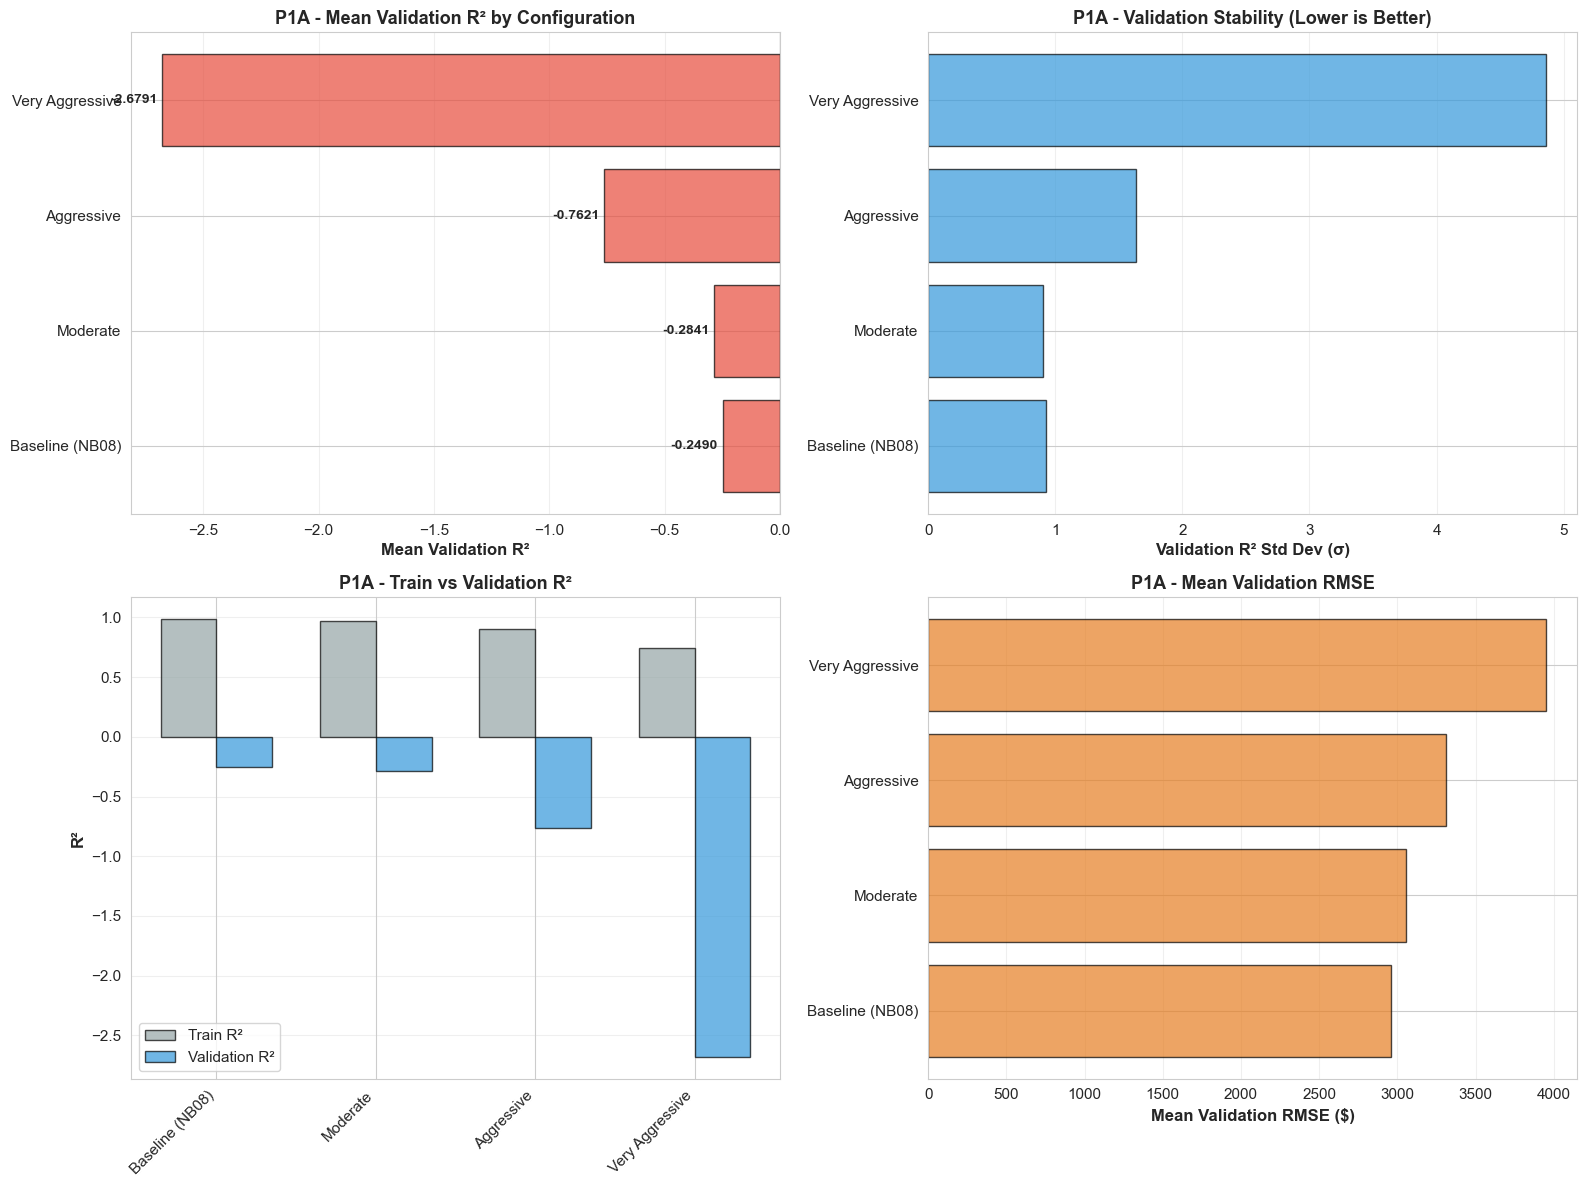


✅ P1A comparison chart saved.


In [8]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Mean Validation R² by Configuration
ax = axes[0, 0]
colors = ['#e74c3c' if r2 < 0 else '#2ecc71' for r2 in p1a_summary['val_R2_mean']]
bars = ax.barh(p1a_summary['config'], p1a_summary['val_R2_mean'], color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for bar, val in zip(bars, p1a_summary['val_R2_mean']):
    width = bar.get_width()
    label_x = width if width > 0 else width - 0.02
    ax.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{val:.4f}', ha='left' if width > 0 else 'right', va='center', 
            fontweight='bold', fontsize=10)

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Mean Validation R²', fontweight='bold', fontsize=12)
ax.set_title('P1A - Mean Validation R² by Configuration', fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)

# Plot 2: Validation R² Standard Deviation
ax = axes[0, 1]
ax.barh(p1a_summary['config'], p1a_summary['val_R2_std'], color='#3498db', alpha=0.7, edgecolor='black')
ax.set_xlabel('Validation R² Std Dev (σ)', fontweight='bold', fontsize=12)
ax.set_title('P1A - Validation Stability (Lower is Better)', fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)

# Plot 3: Train vs Val R² for each config
ax = axes[1, 0]
x = np.arange(len(p1a_summary))
width = 0.35
ax.bar(x - width/2, p1a_summary['train_R2_mean'], width, label='Train R²', color='#95a5a6', alpha=0.7, edgecolor='black')
ax.bar(x + width/2, p1a_summary['val_R2_mean'], width, label='Validation R²', color='#3498db', alpha=0.7, edgecolor='black')
ax.set_ylabel('R²', fontweight='bold', fontsize=12)
ax.set_title('P1A - Train vs Validation R²', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(p1a_summary['config'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 4: Mean RMSE by configuration
ax = axes[1, 1]
ax.barh(p1a_summary['config'], p1a_summary['val_RMSE_mean'], color='#e67e22', alpha=0.7, edgecolor='black')
ax.set_xlabel('Mean Validation RMSE ($)', fontweight='bold', fontsize=12)
ax.set_title('P1A - Mean Validation RMSE', fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(DIAGNOSTICS_DIR / 'p1a_regularization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ P1A comparison chart saved.")

## P1A Detailed Split-by-Split Comparison

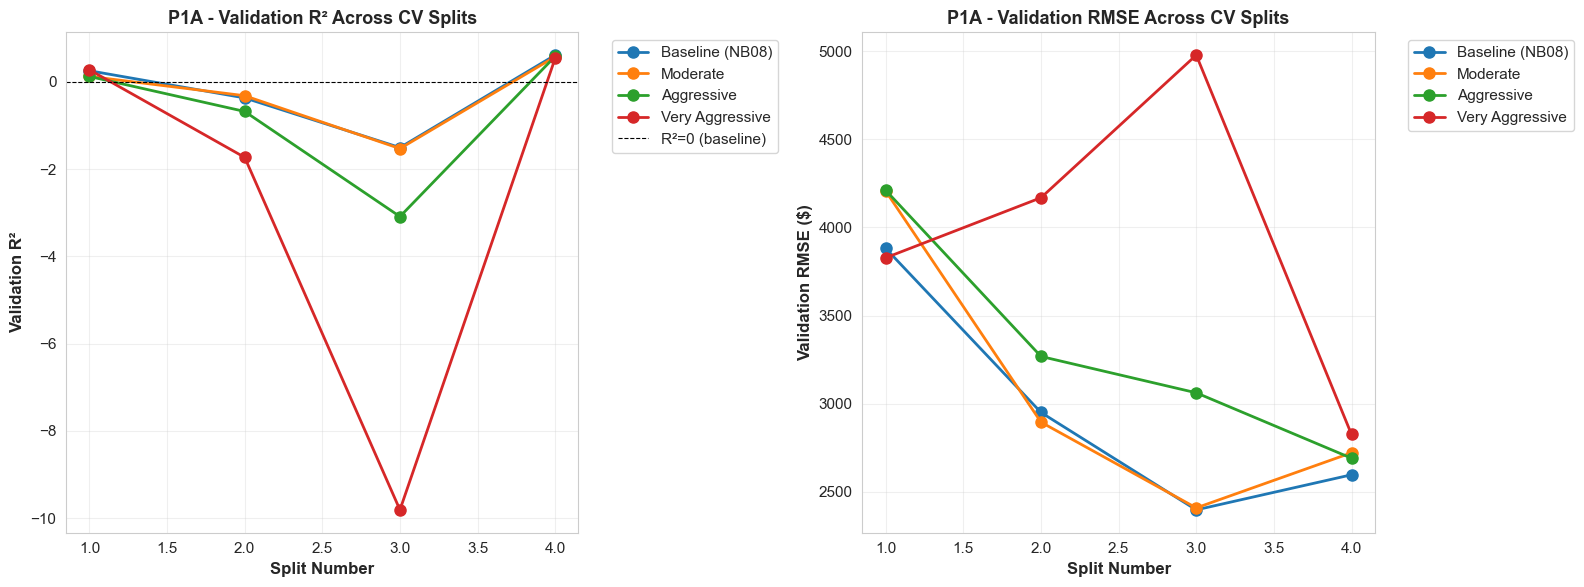


✅ P1A split comparison chart saved.


In [9]:
# Create line plot showing R² across splits for each config
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Validation R² across splits
ax = axes[0]
for config in p1a_summary['config']:
    config_data = p1a_results_df[p1a_results_df['config'] == config]
    ax.plot(config_data['split'], config_data['val_R2'], 'o-', label=config, linewidth=2, markersize=8)

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='R²=0 (baseline)')
ax.set_xlabel('Split Number', fontweight='bold', fontsize=12)
ax.set_ylabel('Validation R²', fontweight='bold', fontsize=12)
ax.set_title('P1A - Validation R² Across CV Splits', fontweight='bold', fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)

# Plot 2: Validation RMSE across splits
ax = axes[1]
for config in p1a_summary['config']:
    config_data = p1a_results_df[p1a_results_df['config'] == config]
    ax.plot(config_data['split'], config_data['val_RMSE'], 'o-', label=config, linewidth=2, markersize=8)

ax.set_xlabel('Split Number', fontweight='bold', fontsize=12)
ax.set_ylabel('Validation RMSE ($)', fontweight='bold', fontsize=12)
ax.set_title('P1A - Validation RMSE Across CV Splits', fontweight='bold', fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DIAGNOSTICS_DIR / 'p1a_cv_splits_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ P1A split comparison chart saved.")

---

# PHASE 2: Test Winning Configuration on P3A

Apply the best-performing P1A configuration to P3A (Pacific) route to check for degradation.

In [10]:
print("="*80)
print("PHASE 2: TESTING WINNING CONFIGURATION ON P3A (PACIFIC)")
print("="*80)

# Test both baseline and winning config on P3A
p3a_all_results = []

# 1. Baseline (NB08) for comparison
print(f"\n{'='*80}")
print("Testing Configuration: Baseline (NB08)")
print("="*80)

baseline_results = expanding_window_cv(
    features=p3a_features,
    labels=labels,
    route_col='P3A_82',
    params=baseline_params,
    n_splits=5,
    config_name='Baseline (NB08)'
)
p3a_all_results.extend(baseline_results)

# 2. Winning configuration from P1A
print(f"\n{'='*80}")
print(f"Testing Configuration: {best_config} (Winner from P1A)")
print("="*80)

winning_params = configs[best_config]
winning_results = expanding_window_cv(
    features=p3a_features,
    labels=labels,
    route_col='P3A_82',
    params=winning_params,
    n_splits=5,
    config_name=best_config
)
p3a_all_results.extend(winning_results)

print("\n" + "="*80)
print("PHASE 2 COMPLETE: P3A configurations tested")
print("="*80)

PHASE 2: TESTING WINNING CONFIGURATION ON P3A (PACIFIC)

Testing Configuration: Baseline (NB08)

Expanding Window CV for P3A_82 - Baseline (NB08):
  Total data points: 1090
  Min train size: 436 (40%)
  Number of splits: 5
  Validation window size: ~130 observations

Split 1:
  Train: 2021-04-14 to 2023-07-21 (n=566)
  Val:   2023-07-24 to 2024-01-30 (n=130)
  Train R²: 0.9962, Val R²: 0.6766, RMSE: $1,390

Split 2:
  Train: 2021-04-14 to 2024-01-30 (n=696)
  Val:   2024-01-31 to 2024-08-05 (n=130)
  Train R²: 0.9954, Val R²: -0.0800, RMSE: $2,214

Split 3:
  Train: 2021-04-14 to 2024-08-05 (n=826)
  Val:   2024-08-06 to 2025-02-12 (n=130)
  Train R²: 0.9930, Val R²: 0.7286, RMSE: $1,506

Split 4:
  Train: 2021-04-14 to 2025-02-12 (n=956)
  Val:   2025-02-13 to 2025-10-06 (n=130)
  Train R²: 0.9927, Val R²: 0.2834, RMSE: $1,633


Testing Configuration: Baseline (NB08) (Winner from P1A)

Expanding Window CV for P3A_82 - Baseline (NB08):
  Total data points: 1090
  Min train size: 436 (4

## Analyze P3A Results

In [11]:
# Convert to DataFrame
p3a_results_df = pd.DataFrame(p3a_all_results)
p3a_results_df['route'] = 'P3A'

# Calculate summary statistics
p3a_summary = p3a_results_df.groupby('config').agg({
    'train_R2': ['mean', 'std'],
    'val_R2': ['mean', 'std', 'min', 'max'],
    'val_RMSE': ['mean', 'std']
}).round(4)

# Flatten column names
p3a_summary.columns = ['_'.join(col).strip() for col in p3a_summary.columns.values]
p3a_summary = p3a_summary.reset_index()

# Sort by mean validation R² (descending)
p3a_summary = p3a_summary.sort_values('val_R2_mean', ascending=False)

print("\n" + "="*80)
print("P3A (PACIFIC) - CONFIGURATION COMPARISON")
print("="*80)
print("\n" + p3a_summary.to_string(index=False))

# Compare with baseline
baseline_r2 = p3a_summary[p3a_summary['config'] == 'Baseline (NB08)']['val_R2_mean'].values[0]
winning_r2 = p3a_summary[p3a_summary['config'] == best_config]['val_R2_mean'].values[0]
r2_diff = winning_r2 - baseline_r2

print("\n" + "="*80)
print("P3A PERFORMANCE COMPARISON")
print(f"  Baseline (NB08):    Mean Val R² = {baseline_r2:.4f}")
print(f"  {best_config}: Mean Val R² = {winning_r2:.4f}")
print(f"  Difference:         {r2_diff:+.4f}")

if r2_diff > -0.05:
    print("\n✅ VERDICT: Winning config maintains P3A performance (acceptable)")
else:
    print("\n⚠️ VERDICT: Winning config degrades P3A performance significantly")
print("="*80)

# Save results
p3a_results_df.to_csv(DIAGNOSTICS_DIR / 'p3a_regularization_cv_results.csv', index=False)
p3a_summary.to_csv(DIAGNOSTICS_DIR / 'p3a_regularization_summary.csv', index=False)

print("\n✅ P3A results saved to diagnostics/")


P3A (PACIFIC) - CONFIGURATION COMPARISON

         config  train_R2_mean  train_R2_std  val_R2_mean  val_R2_std  val_R2_min  val_R2_max  val_RMSE_mean  val_RMSE_std
Baseline (NB08)         0.9943        0.0016       0.4022      0.3499     -0.0800      0.7286      1686.1110      338.7000

P3A PERFORMANCE COMPARISON
  Baseline (NB08):    Mean Val R² = 0.4022
  Baseline (NB08): Mean Val R² = 0.4022
  Difference:         +0.0000

✅ VERDICT: Winning config maintains P3A performance (acceptable)

✅ P3A results saved to diagnostics/


## Visualize P3A Comparison

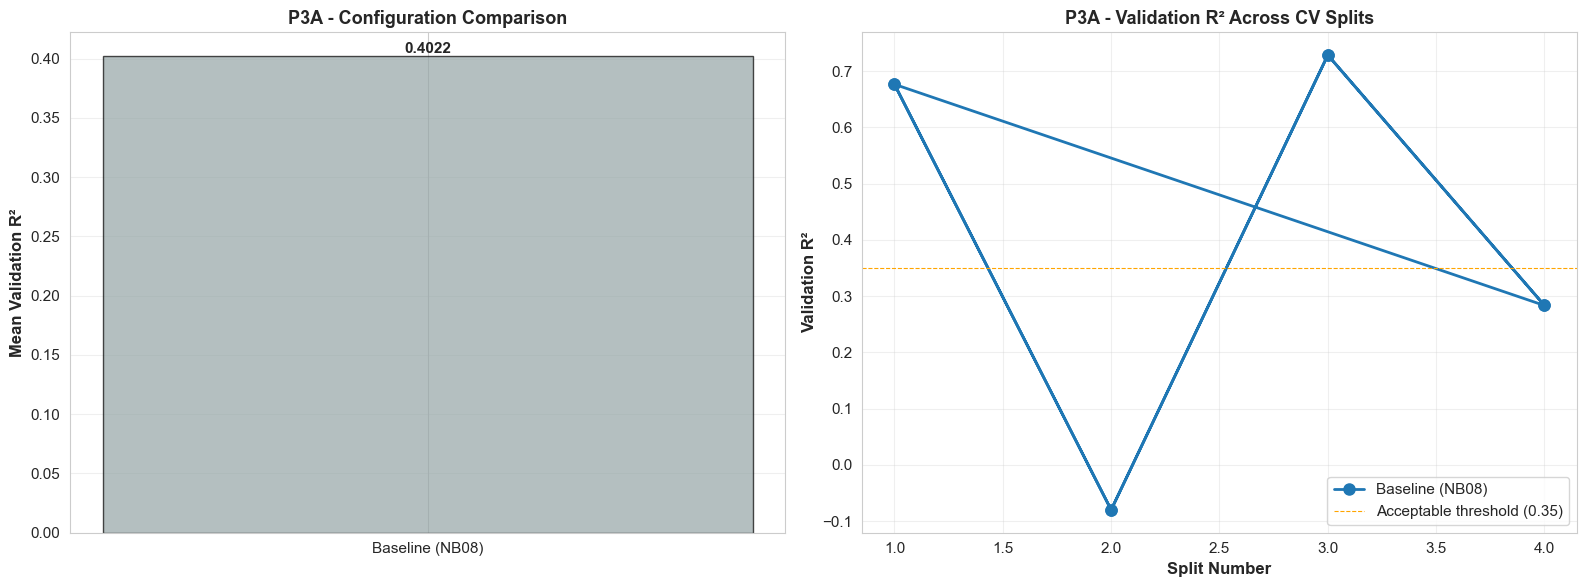


✅ P3A comparison chart saved.


In [12]:
# Create P3A comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mean Validation R² Comparison
ax = axes[0]
colors = ['#95a5a6', '#2ecc71']  # Gray for baseline, green for winning
bars = ax.bar(p3a_summary['config'], p3a_summary['val_R2_mean'], color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for bar, val in zip(bars, p3a_summary['val_R2_mean']):
    ax.text(bar.get_x() + bar.get_width()/2, val, 
            f'{val:.4f}', ha='center', va='bottom', 
            fontweight='bold', fontsize=11)

ax.set_ylabel('Mean Validation R²', fontweight='bold', fontsize=12)
ax.set_title('P3A - Configuration Comparison', fontweight='bold', fontsize=13)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Validation R² across splits
ax = axes[1]
for config in p3a_summary['config']:
    config_data = p3a_results_df[p3a_results_df['config'] == config]
    ax.plot(config_data['split'], config_data['val_R2'], 'o-', label=config, linewidth=2, markersize=8)

ax.axhline(y=0.35, color='orange', linestyle='--', linewidth=0.8, label='Acceptable threshold (0.35)')
ax.set_xlabel('Split Number', fontweight='bold', fontsize=12)
ax.set_ylabel('Validation R²', fontweight='bold', fontsize=12)
ax.set_title('P3A - Validation R² Across CV Splits', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DIAGNOSTICS_DIR / 'p3a_regularization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ P3A comparison chart saved.")

---

# FINAL ANALYSIS: NB08 vs NB09 Comparison

In [13]:
# Load NB08 results for comparison
nb08_results = pd.read_csv(DIAGNOSTICS_DIR / 'expanding_window_cv_results.csv')

# Extract NB08 summary
nb08_summary = nb08_results.groupby('route').agg({
    'val_R2': ['mean', 'std'],
    'val_RMSE': ['mean', 'std']
}).round(4)
nb08_summary.columns = ['_'.join(col).strip() for col in nb08_summary.columns.values]
nb08_summary = nb08_summary.reset_index()
nb08_summary['notebook'] = 'NB08 (Baseline)'

# Create NB09 summary for winning config
nb09_p1a = p1a_results_df[p1a_results_df['config'] == best_config].groupby('route').agg({
    'val_R2': ['mean', 'std'],
    'val_RMSE': ['mean', 'std']
}).round(4)
nb09_p1a.columns = ['_'.join(col).strip() for col in nb09_p1a.columns.values]
nb09_p1a = nb09_p1a.reset_index()
nb09_p1a['notebook'] = f'NB09 ({best_config})'

nb09_p3a = p3a_results_df[p3a_results_df['config'] == best_config].groupby('route').agg({
    'val_R2': ['mean', 'std'],
    'val_RMSE': ['mean', 'std']
}).round(4)
nb09_p3a.columns = ['_'.join(col).strip() for col in nb09_p3a.columns.values]
nb09_p3a = nb09_p3a.reset_index()
nb09_p3a['notebook'] = f'NB09 ({best_config})'

nb09_summary = pd.concat([nb09_p1a, nb09_p3a], ignore_index=True)

# Combine for comparison
final_comparison = pd.concat([nb08_summary, nb09_summary], ignore_index=True)
final_comparison = final_comparison.sort_values(['route', 'notebook'])

print("\n" + "="*80)
print("FINAL COMPARISON: NB08 (BASELINE) vs NB09 (REGULARIZED)")
print("="*80)
print("\n" + final_comparison.to_string(index=False))

# Calculate improvements
print("\n" + "="*80)
print("IMPROVEMENT ANALYSIS")
print("="*80)

for route in ['P1A', 'P3A']:
    nb08_val_r2 = nb08_summary[nb08_summary['route'] == route]['val_R2_mean'].values[0]
    nb09_val_r2 = nb09_summary[nb09_summary['route'] == route]['val_R2_mean'].values[0]
    
    nb08_val_std = nb08_summary[nb08_summary['route'] == route]['val_R2_std'].values[0]
    nb09_val_std = nb09_summary[nb09_summary['route'] == route]['val_R2_std'].values[0]
    
    r2_improvement = nb09_val_r2 - nb08_val_r2
    std_improvement = nb08_val_std - nb09_val_std
    
    print(f"\n{route}:")
    print(f"  Mean Val R²:  {nb08_val_r2:.4f} → {nb09_val_r2:.4f} ({r2_improvement:+.4f})")
    print(f"  Val R² Std:   {nb08_val_std:.4f} → {nb09_val_std:.4f} ({std_improvement:+.4f})")
    
    if r2_improvement > 0.05:
        print(f"  ✅ SIGNIFICANT IMPROVEMENT")
    elif r2_improvement > 0:
        print(f"  ✅ MODERATE IMPROVEMENT")
    elif r2_improvement > -0.05:
        print(f"  ⚠️  MINOR DEGRADATION (acceptable)")
    else:
        print(f"  ❌ SIGNIFICANT DEGRADATION")

# Save final comparison
final_comparison.to_csv(DIAGNOSTICS_DIR / 'nb08_vs_nb09_comparison.csv', index=False)
print("\n✅ Final comparison saved to diagnostics/nb08_vs_nb09_comparison.csv")


FINAL COMPARISON: NB08 (BASELINE) vs NB09 (REGULARIZED)

route  val_R2_mean  val_R2_std  val_RMSE_mean  val_RMSE_std               notebook
  P1A      -0.2490      0.9300      2955.5576      657.8826        NB08 (Baseline)
  P1A      -0.2490      0.9300      2955.5576      657.8826 NB09 (Baseline (NB08))
  P3A       0.4022      0.3779      1686.1110      365.8378        NB08 (Baseline)
  P3A       0.4022      0.3499      1686.1110      338.7000 NB09 (Baseline (NB08))

IMPROVEMENT ANALYSIS

P1A:
  Mean Val R²:  -0.2490 → -0.2490 (+0.0000)
  Val R² Std:   0.9300 → 0.9300 (+0.0000)
  ⚠️  MINOR DEGRADATION (acceptable)

P3A:
  Mean Val R²:  0.4022 → 0.4022 (+0.0000)
  Val R² Std:   0.3779 → 0.3499 (+0.0280)
  ⚠️  MINOR DEGRADATION (acceptable)

✅ Final comparison saved to diagnostics/nb08_vs_nb09_comparison.csv


## Create Final Comparison Visualization

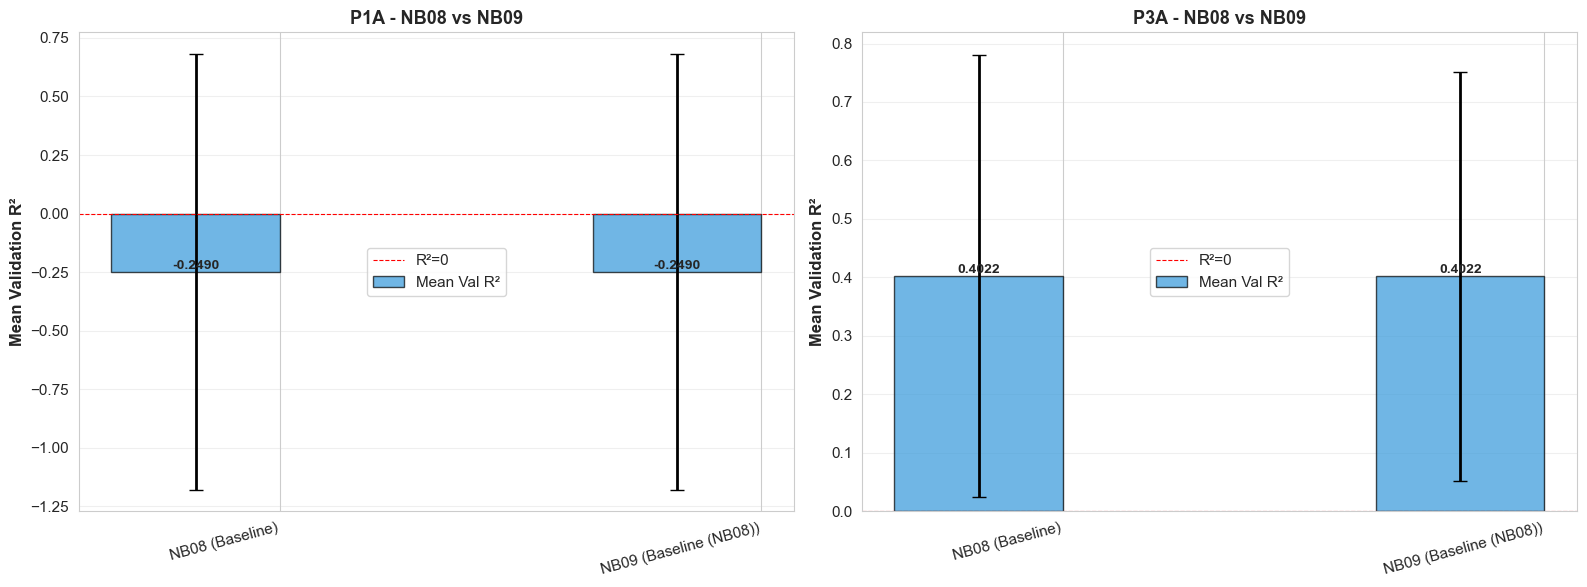


✅ Final comparison chart saved.


In [14]:
# Create side-by-side comparison chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

routes = ['P1A', 'P3A']
for idx, route in enumerate(routes):
    ax = axes[idx]
    
    route_data = final_comparison[final_comparison['route'] == route]
    
    x = np.arange(len(route_data))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, route_data['val_R2_mean'], width, 
                   label='Mean Val R²', color='#3498db', alpha=0.7, edgecolor='black')
    
    # Add error bars for standard deviation
    ax.errorbar(x - width/2, route_data['val_R2_mean'], yerr=route_data['val_R2_std'],
                fmt='none', color='black', capsize=5, linewidth=2)
    
    # Add value labels
    for bar, val in zip(bars1, route_data['val_R2_mean']):
        ax.text(bar.get_x() + bar.get_width()/2, val, 
                f'{val:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    ax.axhline(y=0, color='red', linestyle='--', linewidth=0.8, label='R²=0')
    ax.set_ylabel('Mean Validation R²', fontweight='bold', fontsize=12)
    ax.set_title(f'{route} - NB08 vs NB09', fontweight='bold', fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels(route_data['notebook'], rotation=15, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(DIAGNOSTICS_DIR / 'nb08_vs_nb09_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Final comparison chart saved.")

---

# Summary & Conclusions

In [15]:
print("\n" + "="*80)
print("NOTEBOOK 09: REGULARIZATION FOR TEMPORAL STABILITY - COMPLETE")
print("="*80)

print("\n📊 CONFIGURATIONS TESTED:")
print(f"  ✅ P1A (Atlantic): {len(configs)} configurations")
print(f"  ✅ P3A (Pacific): 2 configurations (Baseline + Winner)")

print("\n🏆 WINNING CONFIGURATION:")
print(f"  {best_config}")
for param, value in configs[best_config].items():
    if param != 'verbosity' and param != 'random_state':
        baseline_val = baseline_params[param]
        if value != baseline_val:
            print(f"    {param}: {baseline_val} → {value}")

print("\n📈 P1A (ATLANTIC) RESULTS:")
p1a_nb08 = nb08_summary[nb08_summary['route'] == 'P1A']['val_R2_mean'].values[0]
p1a_nb09 = nb09_summary[nb09_summary['route'] == 'P1A']['val_R2_mean'].values[0]
print(f"  NB08 (Baseline):    Mean Val R² = {p1a_nb08:.4f}")
print(f"  NB09 (Regularized): Mean Val R² = {p1a_nb09:.4f}")
print(f"  Improvement:        {p1a_nb09 - p1a_nb08:+.4f}")

if p1a_nb09 > 0:
    print("  ✅ SUCCESS: P1A Mean R² is now POSITIVE")
elif p1a_nb09 > p1a_nb08:
    print("  ⚠️  PARTIAL SUCCESS: P1A improved but still negative")
else:
    print("  ❌ FAILURE: Regularization did not help P1A")

print("\n📈 P3A (PACIFIC) RESULTS:")
p3a_nb08 = nb08_summary[nb08_summary['route'] == 'P3A']['val_R2_mean'].values[0]
p3a_nb09 = nb09_summary[nb09_summary['route'] == 'P3A']['val_R2_mean'].values[0]
print(f"  NB08 (Baseline):    Mean Val R² = {p3a_nb08:.4f}")
print(f"  NB09 (Regularized): Mean Val R² = {p3a_nb09:.4f}")
print(f"  Change:             {p3a_nb09 - p3a_nb08:+.4f}")

if p3a_nb09 > 0.35:
    print("  ✅ P3A maintains strong performance")
else:
    print("  ⚠️  P3A performance degraded")

print("\n🎯 FINAL RECOMMENDATION:")
if p1a_nb09 > 0 and p3a_nb09 > 0.35:
    print(f"  ✅ Use {best_config} for BOTH routes")
    print("  ✅ Regularization successfully improved P1A without hurting P3A")
elif p1a_nb09 > p1a_nb08 and p3a_nb09 > 0.30:
    print(f"  ⚠️  Route-specific hyperparameters recommended:")
    print(f"      P1A: {best_config}")
    print(f"      P3A: Baseline (NB08) or {best_config} (similar performance)")
else:
    print("  ⚠️  Regularization provided limited benefit")
    print("  📝 Thesis conclusion: P3A is predictable, P1A requires adaptive methods")

print("\n" + "="*80)
print("📂 All outputs saved to: data/diagnostics/")
print("="*80)

print("\n📁 Generated Files:")
import os
nb09_files = [
    'p1a_regularization_cv_results.csv',
    'p1a_regularization_summary.csv',
    'p1a_regularization_comparison.png',
    'p1a_cv_splits_comparison.png',
    'p3a_regularization_cv_results.csv',
    'p3a_regularization_summary.csv',
    'p3a_regularization_comparison.png',
    'nb08_vs_nb09_comparison.csv',
    'nb08_vs_nb09_comparison_chart.png'
]

for file in nb09_files:
    filepath = DIAGNOSTICS_DIR / file
    if filepath.exists():
        size = os.path.getsize(filepath) / 1024
        print(f"  ✅ {file:<50} ({size:.1f} KB)")
    else:
        print(f"  ❌ {file:<50} (not found)")


NOTEBOOK 09: REGULARIZATION FOR TEMPORAL STABILITY - COMPLETE

📊 CONFIGURATIONS TESTED:
  ✅ P1A (Atlantic): 4 configurations
  ✅ P3A (Pacific): 2 configurations (Baseline + Winner)

🏆 WINNING CONFIGURATION:
  Baseline (NB08)

📈 P1A (ATLANTIC) RESULTS:
  NB08 (Baseline):    Mean Val R² = -0.2490
  NB09 (Regularized): Mean Val R² = -0.2490
  Improvement:        +0.0000
  ❌ FAILURE: Regularization did not help P1A

📈 P3A (PACIFIC) RESULTS:
  NB08 (Baseline):    Mean Val R² = 0.4022
  NB09 (Regularized): Mean Val R² = 0.4022
  Change:             +0.0000
  ✅ P3A maintains strong performance

🎯 FINAL RECOMMENDATION:
  ⚠️  Regularization provided limited benefit
  📝 Thesis conclusion: P3A is predictable, P1A requires adaptive methods

📂 All outputs saved to: data/diagnostics/

📁 Generated Files:
  ✅ p1a_regularization_cv_results.csv                  (2.7 KB)
  ✅ p1a_regularization_summary.csv                     (0.4 KB)
  ✅ p1a_regularization_comparison.png                  (377.5 KB)
  ✅ 